In [1]:
import os
from azure.cognitiveservices.vision.computervision import ComputerVisionClient
from azure.cognitiveservices.vision.computervision.models import OperationStatusCodes
from msrest.authentication import CognitiveServicesCredentials
from dotenv import load_dotenv
from src.utils import *
from src.utils_azure import *
load_dotenv('/mnt/d/docker_volume/room_of_nhanhuynh/ai_butler/CAD-ShibaSangyo/official/.env')



endpoint = os.environ['AZURE_SHIBA_ENDPOINT_KEY']
subscription_key = os.environ['AZURE_SHIBA_SUBSCRIPTION_KEY']
COMPUTERVISION_CLIENT = ComputerVisionClient(endpoint, CognitiveServicesCredentials(subscription_key))

/home/bu0ai/anaconda3/envs/shiba/lib/python3.10/site-packages/torchvision/transforms/functional_tensor.py:5: UserWarning: The torchvision.transforms.functional_tensor module is deprecated in 0.15 and will be **removed in 0.17**. Please don't rely on it. You probably just need to use APIs in torchvision.transforms.functional or in torchvision.transforms.v2.functional.
  warnings.warn(


In [2]:
model_restore_resolution = '/mnt/d/docker_volume/room_of_nhanhuynh/ai_butler/CAD-ShibaSangyo/full_build_from_scratch_nhanhuynh/GFPGAN/experiments/pretrained_models/GFPGANv1.3.pth'


model = RRDBNet(num_in_ch=3, num_out_ch=3, num_feat=64, num_block=23, num_grow_ch=32, scale=2)
bg_upsampler = RealESRGANer(
                            scale=2,
                            model_path='https://github.com/xinntao/Real-ESRGAN/releases/download/v0.2.1/RealESRGAN_x2plus.pth',
                            model=model,
                            tile=400,
                            tile_pad=10,
                            pre_pad=0,
                            half=True) 

# Setup Parammeter for GFPGANer
restorer = GFPGANer(model_path=model_restore_resolution,
                    upscale=2,
                    arch='clean',
                    channel_multiplier=2,
                    bg_upsampler=bg_upsampler)


/home/bu0ai/anaconda3/envs/shiba/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/bu0ai/anaconda3/envs/shiba/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [3]:
image_path = 'assets/outfile.png'
det_draw_path = r'/mnt/d/docker_volume/room_of_nhanhuynh/ai_butler/CAD-ShibaSangyo/demo/weight/draw_231229/best.pt'
det_code_path = r'weight/best_core_pretrain_2106.pt'

raw_image_pil = upscale_image(image_path,
                         restorer,
                         des_path= '/mnt/d/docker_volume/room_of_nhanhuynh/ai_butler/CAD-ShibaSangyo/full_build_from_scratch_nhanhuynh/tmpFile/temp_azure/temp_azure_cad')
raw_image_pil = Image.open(raw_image_pil)

det_draw_model = load_yolo(det_draw_path)
det_code_model = load_yolo(det_code_path)

result_draw_df = yolo_inference(raw_image_pil, det_draw_model, type='draw')
raw_code_df = yolo_inference(raw_image_pil, det_code_model, type='code')
base_image_pil, draw_location_list = split_images(raw_image_pil.copy(), result_draw_df)
basic_info_dict = get_basic_info(base_image_pil, COMPUTERVISION_CLIENT)

Done


/mnt/d/docker_volume/room_of_nhanhuynh/ai_butler/CAD-ShibaSangyo/full_build_from_scratch_nhanhuynh/src/utils_azure.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  match_builder_name.sort_values(by='top', inplace=True)
/mnt/d/docker_volume/room_of_nhanhuynh/ai_butler/CAD-ShibaSangyo/full_build_from_scratch_nhanhuynh/src/utils_azure.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  match_anken.sort_values(by='top', inplace=True)


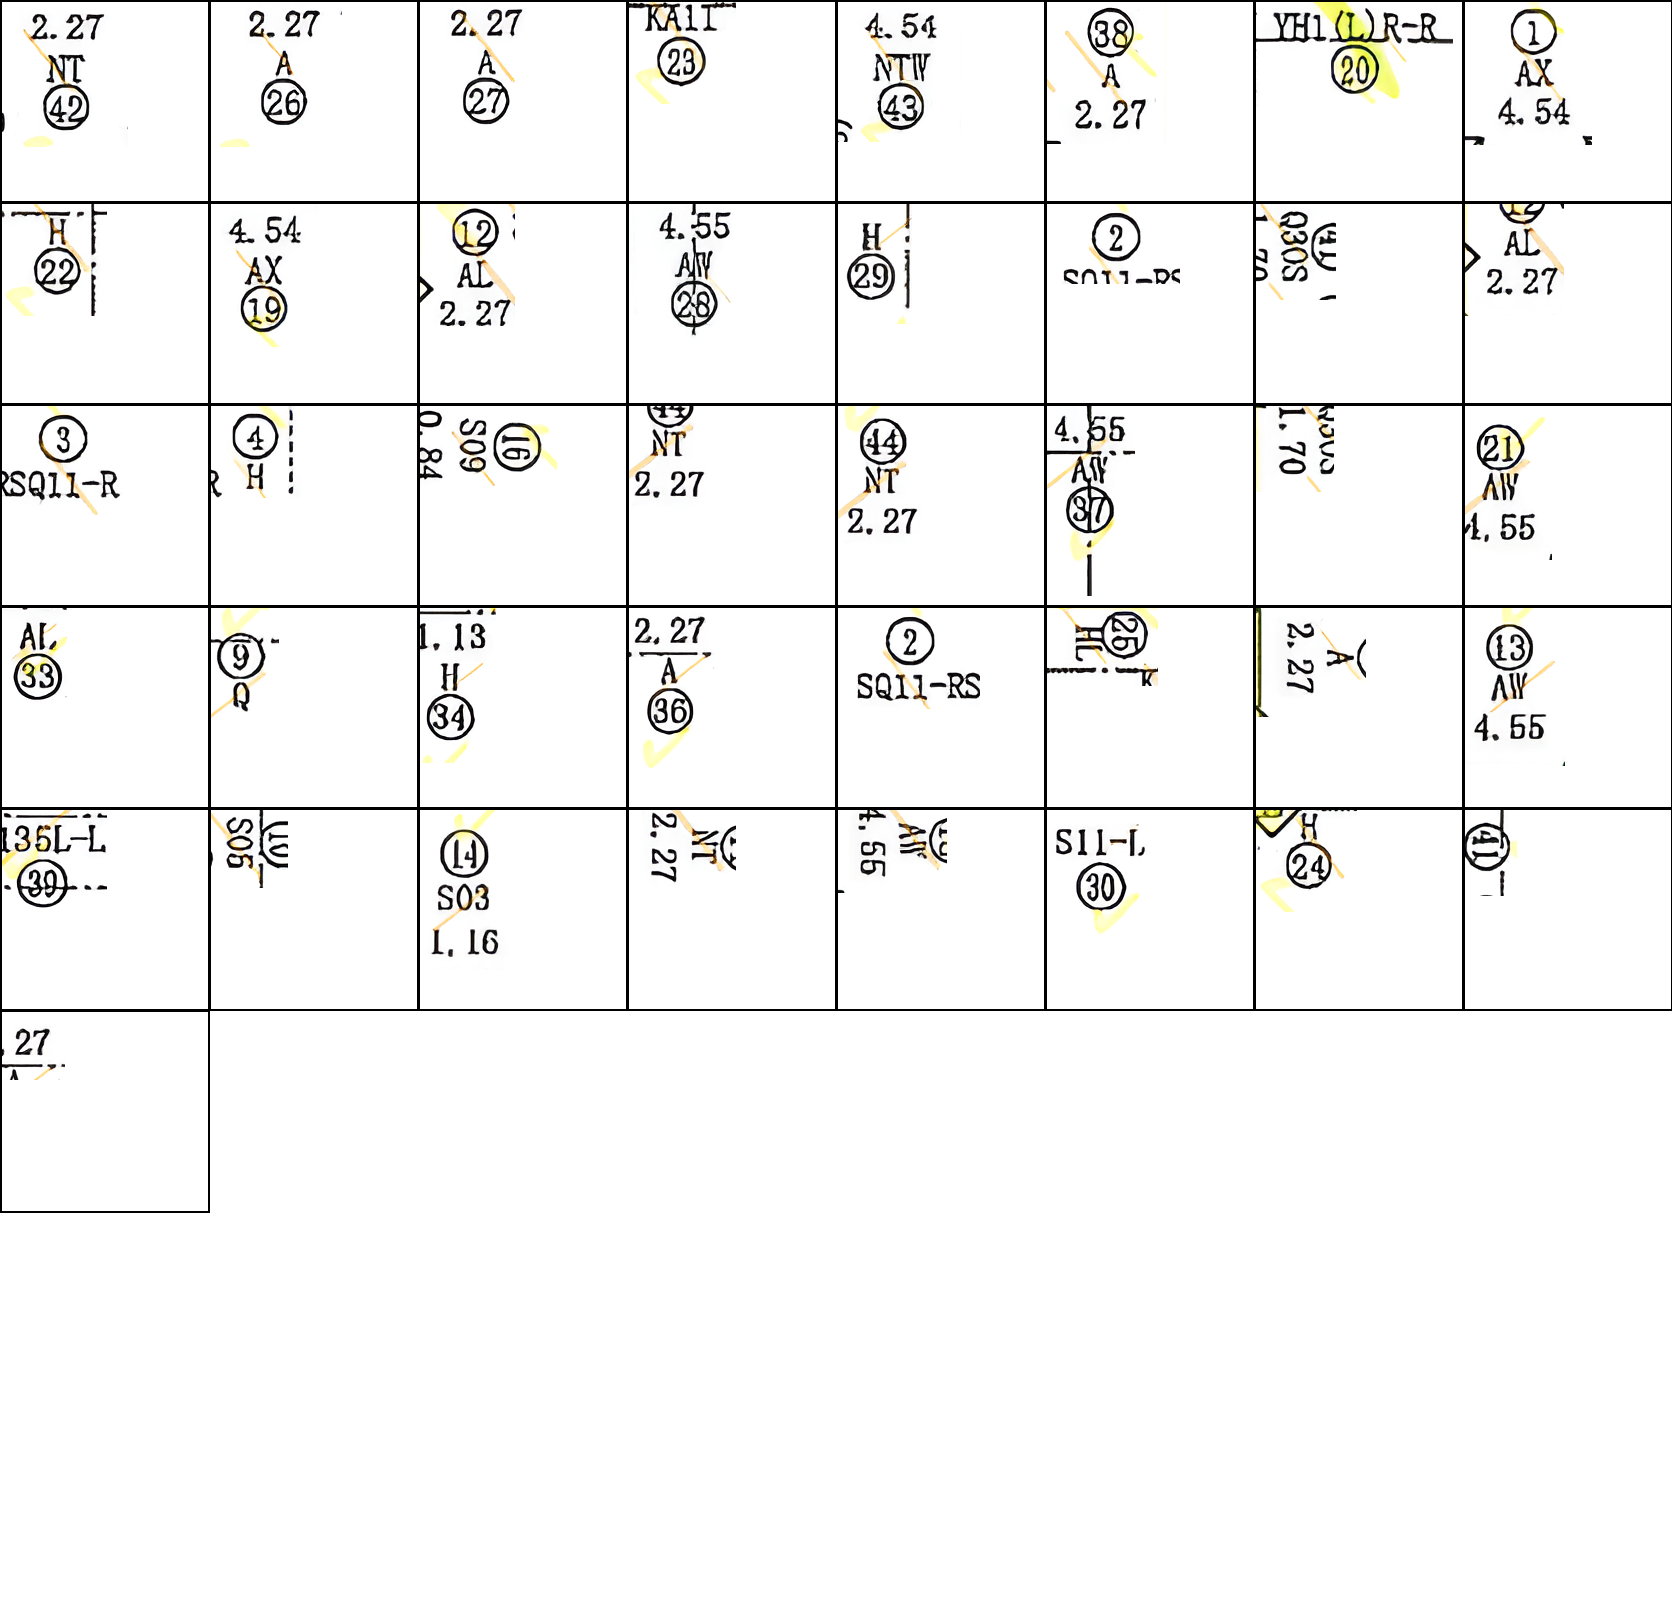

: 

In [4]:
code_df = raw_code_df[raw_code_df.boxes.apply(lambda b: calc_ovl(b, [739, 1610, 3250, 4091]) > 0.5)]
code_df.reset_index(drop=True, inplace=True)
num_cell, cell_width, cell_height = get_cell_size(code_df)
concat_image_pil = gen_grid_image(raw_image_pil, code_df, num_cell, cell_width, cell_height)
concat_image_pil

In [5]:
draw_words, draw_boxes = ocr_azure_cad(concat_image_pil.copy(), COMPUTERVISION_CLIENT)
draw_boxes

[[5, 4, 61, 29],
 [374, 9, 404, 36],
 [1121, 13, 1134, 38],
 [194, 14, 234, 38],
 [564, 15, 583, 36],
 [742, 12, 765, 35],
 [919, 9, 947, 37],
 [18, 34, 51, 57],
 [206, 46, 225, 67],
 [383, 41, 408, 63],
 [567, 44, 582, 63],
 [737, 41, 763, 65],
 [924, 41, 953, 65],
 [1094, 45, 1162, 69],
 [15, 65, 50, 85],
 [185, 73, 241, 95],
 [367, 71, 421, 93],
 [546, 72, 599, 95],
 [728, 71, 781, 93],
 [907, 70, 965, 93],
 [6, 125, 61, 148],
 [184, 122, 239, 145],
 [386, 129, 412, 152],
 [565, 132, 592, 149],
 [730, 125, 770, 146],
 [922, 120, 978, 144],
 [1107, 127, 1131, 154],
 [21, 154, 48, 177],
 [199, 152, 226, 174],
 [390, 160, 407, 182],
 [564, 154, 613, 179],
 [737, 156, 768, 178],
 [908, 152, 1005, 178],
 [1109, 161, 1129, 182],
 [15, 184, 47, 206],
 [195, 182, 224, 203],
 [368, 189, 423, 212],
 [550, 187, 605, 211],
 [937, 183, 963, 206],
 [1092, 188, 1147, 212],
 [16, 247, 47, 268],
 [192, 246, 222, 266],
 [372, 244, 527, 270],
 [557, 241, 598, 274],
 [729, 240, 784, 264],
 [911, 242, 9

In [7]:
len(draw_boxes)

110

In [3]:
from PIL import Image

image_cad = Image.open('/mnt/d/docker_volume/room_of_nhanhuynh/ai_butler/CAD-ShibaSangyo/demo/sample/sample-01.png')
COMPUTERVISION_CLIENT = ComputerVisionClient(endpoint, CognitiveServicesCredentials(subscription_key))

In [4]:
model_restore_resolution = '/mnt/d/docker_volume/room_of_nhanhuynh/ai_butler/CAD-ShibaSangyo/full_build_from_scratch_nhanhuynh/GFPGAN/experiments/pretrained_models/GFPGANv1.3.pth'

model = RRDBNet(num_in_ch=3, num_out_ch=3, num_feat=64, num_block=23, num_grow_ch=32, scale=2)
bg_upsampler = RealESRGANer(
                            scale=2,
                            model_path='https://github.com/xinntao/Real-ESRGAN/releases/download/v0.2.1/RealESRGAN_x2plus.pth',
                            model=model,
                            tile=400,
                            tile_pad=10,
                            pre_pad=0,
                            half=True) 

# Setup Parammeter for GFPGANer
restorer = GFPGANer(model_path=model_restore_resolution,
                    upscale=1.5,
                    arch='clean',
                    channel_multiplier=2,
                    bg_upsampler=bg_upsampler)

words, boxes = ocr_azure_cad(image_cad.copy(), COMPUTERVISION_CLIENT)

In [5]:
data_df = pd.DataFrame({'words': words, 'boxes': boxes})
data_df[['left', 'top', 'right', 'bottom']] = data_df['boxes'].apply(pd.Series)
data_df['words'] = data_df['words'].apply(lambda e: e.replace(' ', ''))
data_df

,words,boxes,left,top,right,bottom
0,横架材接合金物特記,"[246, 212, 541, 250]",246,212,541,250
1,※ZATIIまたはZATⅢ取付不可の,"[1258, 230, 1973, 281]",1258,230,1973,281
2,耐力壁及び準耐力壁,"[3485, 239, 3739, 277]",3485,239,3739,277
3,柱端部の接合方法,"[3959, 226, 4169, 269]",3959,226,4169,269
4,安合部種類,"[4583, 238, 4708, 279]",4583,238,4708,279
...,...,...,...,...,...,...
392,縮尺,"[3279, 3265, 3369, 3295]",3279,3265,3369,3295
393,2023.02.20,"[4208, 3246, 4467, 3287]",4208,3246,4467,3287
394,東京都第40416号,"[841, 3315, 1125, 3346]",841,3315,1125,3346
395,壁量·金物·壁パネル図,"[2628, 3292, 3259, 3348]",2628,3292,3259,3348


In [6]:
construct_type = data_df[data_df.words.str.contains('ids', case=False)]
construct_type_str = construct_type.words.tolist()[0]
construct_type_str

'IDS-Ⅵ型'

In [12]:
title_builder_name = process.extractOne("分 譲 住 宅 建 築 販 売 設 計 施 工", words, scorer=fuzz.WRatio)
title_builder_name_idx = title_builder_name[2]
title_builder_name_box = boxes[title_builder_name_idx]
title_builder_name_width = (title_builder_name_box[2] - title_builder_name_box[0]) * 0.5
match_builder_name = data_df[(data_df.left < (title_builder_name_box[2] + title_builder_name_width)) & (data_df.right > title_builder_name_box[0]) &
                                    (data_df.top > title_builder_name_box[1])]

match_builder_name.sort_values(by='top', inplace=True)
match_builder_name = match_builder_name[(match_builder_name.iloc[0].top < match_builder_name.bottom) & (match_builder_name.iloc[0].bottom > match_builder_name.top)]
match_builder_name_str = ' '.join(match_builder_name.sort_values(by='left').words.tolist())


/tmp/ipykernel_3430639/644715915.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  match_builder_name.sort_values(by='top', inplace=True)


In [14]:
match_builder_name_str

'タクトホーム株式会社'

In [4]:
import os

os.removedirs('/mnt/d/docker_volume/room_of_nhanhuynh/ai_butler/CAD-ShibaSangyo/lala')